# Configurar Spark para Python Jupyter



In [ ]:
import os
import sys
os.environ["SPARK_HOME"] = "/opt/cloudera/parcels/CDH-6.2.0-1.cdh6.2.0.p0.967373/lib/spark"
os.environ["PYLIB"] = os.environ["SPARK_HOME"] + "/python/lib"
os.environ["PYSPARK_PYTHON"] = "/home/hadoop/anaconda2/bin/python" 
os.environ["PYSPARK_DRIVER_PYTHON"] = "/home/hadoop/anaconda2/bin/python"
sys.path.insert(0, os.environ["PYLIB"] +"/py4j-0.10.7-src.zip")
sys.path.insert(0, os.environ["PYLIB"] +"/pyspark.zip")

In [ ]:
import findspark
findspark.init()

# Crear objeto SparkSession para conectar al cluster Spark

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("Data Source API using PySpark Demo") \
    .getOrCreate()

In [ ]:
print(spark.sparkContext.appName)

Data Source API using PySpark Demo


# API de fuente de datos formato de archivo CSV con PySpark

<a href='https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader'>PySpark API Docs</a>
<br/>
<a href='https://spark.apache.org/docs/2.4.3/sql-data-sources.html#data-sources'>Spark Data Source Guide</a> 

In [ ]:
# transaction_detail.csv el archivo esta ubicado en el HDFS: /user/hadoop/data/pyspark_input_data/csv
transaction_detail_df = spark.read.csv("/user/hadoop/data/pyspark_input_data/csv")

In [ ]:
transaction_detail_df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: string (nullable = true)
 |-- _c4: string (nullable = true)
 |-- _c5: string (nullable = true)
 |-- _c6: string (nullable = true)
 |-- _c7: string (nullable = true)



In [ ]:
transaction_detail_df.show(2, False)

+------------------+---------------------+----------------------------------+------------------------+--------------------+--------------+---------------------+------------------------+
|_c0               |_c1                  |_c2                               |_c3                     |_c4                 |_c5           |_c6                  |_c7                     |
+------------------+---------------------+----------------------------------+------------------------+--------------------+--------------+---------------------+------------------------+
|transaction_amount|transaction_card_type|transaction_ecommerce_website_name|transaction_country_name|transaction_datetime|transaction_id|transaction_city_name|transaction_product_name|
|50.85             |MasterCard           |www.ebay.com                      |India                   |2019-05-14 15:24:12 |1             |Mumbai               |Laptop                  |
+------------------+---------------------+----------------------------

In [ ]:
#transaction_detail_df = spark.read.option("header", True).csv("/user/hadoop/data/pyspark_input_data/csv")

transaction_detail_df = spark.read.option("header", True).option("inferSchema", True).csv("/user/hadoop/data/pyspark_input_data/csv")

In [ ]:
transaction_detail_df.printSchema()

root
 |-- transaction_amount: double (nullable = true)
 |-- transaction_card_type: string (nullable = true)
 |-- transaction_ecommerce_website_name: string (nullable = true)
 |-- transaction_country_name: string (nullable = true)
 |-- transaction_datetime: timestamp (nullable = true)
 |-- transaction_id: integer (nullable = true)
 |-- transaction_city_name: string (nullable = true)
 |-- transaction_product_name: string (nullable = true)



In [ ]:
transaction_detail_df.count()

1000

In [ ]:
transaction_detail_df.show(2, False)

+------------------+---------------------+----------------------------------+------------------------+--------------------+--------------+---------------------+------------------------+
|transaction_amount|transaction_card_type|transaction_ecommerce_website_name|transaction_country_name|transaction_datetime|transaction_id|transaction_city_name|transaction_product_name|
+------------------+---------------------+----------------------------------+------------------------+--------------------+--------------+---------------------+------------------------+
|50.85             |MasterCard           |www.ebay.com                      |India                   |2019-05-14 15:24:12 |1             |Mumbai               |Laptop                  |
|259.12            |MasterCard           |www.amazon.com                    |India                   |2019-05-14 15:24:13 |2             |Pune                 |Wrist Band              |
+------------------+---------------------+----------------------------

In [ ]:
transaction_detail_df_stg1 = transaction_detail_df.select("transaction_card_type", "transaction_country_name", "transaction_amount")

In [ ]:
transaction_detail_df_stg1.show(5, False)

+---------------------+------------------------+------------------+
|transaction_card_type|transaction_country_name|transaction_amount|
+---------------------+------------------------+------------------+
|MasterCard           |India                   |50.85             |
|MasterCard           |India                   |259.12            |
|MasterCard           |United States           |328.16            |
|Visa                 |Inida                   |399.06            |
|Visa                 |Italy                   |194.52            |
+---------------------+------------------------+------------------+
only showing top 5 rows



In [ ]:
transaction_detail_df_stg1.groupby('transaction_card_type').agg({'transaction_amount': 'sum'}).show()

+---------------------+-----------------------+
|transaction_card_type|sum(transaction_amount)|
+---------------------+-----------------------+
|              Maestro|      91002.73999999998|
|                 Visa|      88020.94000000006|
|           MasterCard|     100876.58000000007|
+---------------------+-----------------------+



In [ ]:
transaction_detail_df_stg1.groupby('transaction_country_name').agg({'transaction_amount': 'sum'}).show()

+------------------------+-----------------------+
|transaction_country_name|sum(transaction_amount)|
+------------------------+-----------------------+
|               Singapore|     23082.309999999998|
|                  France|     19675.550000000007|
|                   India|      126909.0200000001|
|           United States|               18764.22|
|                   Italy|               19831.75|
|                Thailand|      17041.25999999999|
|                  Israel|     16599.459999999995|
|                   Inida|     16664.040000000005|
|          United Kingdom|     21332.649999999998|
+------------------------+-----------------------+



In [ ]:
#transaction_detail_df_stg1.groupby('transaction_country_name').agg({'transaction_amount': 'count'}).show()
transaction_detail_df_stg1.groupby('transaction_country_name').count().show()

+------------------------+-----+
|transaction_country_name|count|
+------------------------+-----+
|               Singapore|   80|
|                  France|   70|
|                   India|  441|
|           United States|   68|
|                   Italy|   75|
|                Thailand|   67|
|                  Israel|   55|
|                   Inida|   65|
|          United Kingdom|   79|
+------------------------+-----+



In [ ]:
transaction_detail_df_stg1.filter(transaction_detail_df_stg1.transaction_country_name == 'India').show(5, False)

+---------------------+------------------------+------------------+
|transaction_card_type|transaction_country_name|transaction_amount|
+---------------------+------------------------+------------------+
|MasterCard           |India                   |50.85             |
|MasterCard           |India                   |259.12            |
|Maestro              |India                   |415.65            |
|MasterCard           |India                   |467.12            |
|Visa                 |India                   |361.61            |
+---------------------+------------------------+------------------+
only showing top 5 rows



In [ ]:
transaction_detail_df_stg1.select("transaction_country_name").distinct().show()

+------------------------+
|transaction_country_name|
+------------------------+
|               Singapore|
|                  France|
|                   India|
|           United States|
|                   Italy|
|                Thailand|
|                  Israel|
|                   Inida|
|          United Kingdom|
+------------------------+



In [ ]:
transaction_detail_df_stg1.createTempView("transaction_detail_subset")

In [ ]:
transaction_detail_count_by_country_df = spark.sql("select transaction_country_name, count(*) as transaction_count from transaction_detail_subset group by transaction_country_name")
transaction_detail_count_by_country_df.show()

+------------------------+-----------------+
|transaction_country_name|transaction_count|
+------------------------+-----------------+
|               Singapore|               80|
|                  France|               70|
|                   India|              441|
|           United States|               68|
|                   Italy|               75|
|                Thailand|               67|
|                  Israel|               55|
|                   Inida|               65|
|          United Kingdom|               79|
+------------------------+-----------------+



# Graficos de muestra usando el paquete Seaborn Python

In [ ]:
# importar paquete seaborn
import seaborn as sns
sns.set()

# Matplotlib para personalizacion adicional
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
transaction_detail_count_by_country_pd_df = transaction_detail_count_by_country_df.toPandas()

In [ ]:
pkmn_type_colors = ['#78C850',  # Grass
                    '#F08030',  # Fire
                    '#6890F0',  # Water
                    '#A8B820',  # Bug
                    '#A8A878',  # Normal
                    '#A040A0',  # Poison
                    '#F8D030',  # Electric
                    '#E0C068',  # Ground
                    '#EE99AC',  # Fairy
                    '#C03028',  # Fighting
                    '#F85888',  # Psychic
                    '#B8A038',  # Rock
                    '#705898',  # Ghost
                    '#98D8D8',  # Ice
                    '#7038F8',  # Dragon
                   ]

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

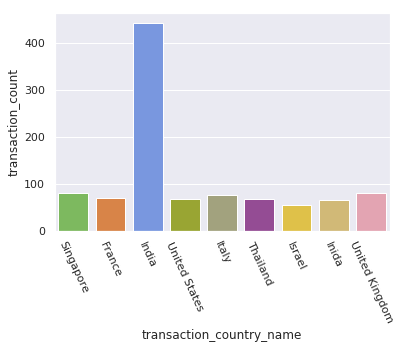

In [ ]:
# Bar Plot
sns.barplot(x='transaction_country_name', y='transaction_count', data=transaction_detail_count_by_country_pd_df, palette=pkmn_type_colors)
 
# Rotate x-labels
plt.xticks(rotation=-65)

In [ ]:
transaction_detail_count_by_country_pd_df.head(25)

transaction_country_name  transaction_count
0                Singapore                 80
1                   France                 70
2                    India                441
3            United States                 68
4                    Italy                 75
5                 Thailand                 67
6                   Israel                 55
7                    Inida                 65
8           United Kingdom                 79

(array([  0., 100., 200., 300., 400., 500.]),
 <a list of 6 Text xticklabel objects>)

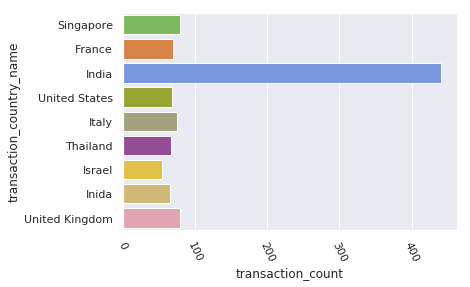

In [ ]:
# Bar Plot - Horizontal
sns.barplot(x='transaction_count', y='transaction_country_name', data=transaction_detail_count_by_country_pd_df, palette=pkmn_type_colors)
 
# Rotate x-labels
plt.xticks(rotation=-65)